<a href="https://colab.research.google.com/github/ilshady/Docs/blob/master/HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
import re, string 
import spacy
import sys
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
SW = set(stopwords.words('english'))
from gensim.models import Word2Vec
%matplotlib inline

In [0]:
df = pd.read_csv('BBC news dataset.csv')

In [12]:
#Tokenize words in each article
tokenization = df['description'].apply(word_tokenize)
print(tokenization)

0       [chelsea, sack, mutu, chelsea, have, sacked, a...
1       [record, fails, to, lift, lacklustre, meet, ye...
2       [edu, describes, tunnel, fracas, arsenals, edu...
3       [ogara, revels, in, ireland, victory, ireland,...
4       [unclear, future, for, striker, baros, liverpo...
                              ...                        
2405    [gm, in, crunch, talks, on, fiat, future, fiat...
2406    [uk, firm, faces, venezuelan, land, row, venez...
2407    [winndixie, files, for, bankruptcy, us, superm...
2408    [yangtze, electrics, profits, double, yangtze,...
2409    [algeria, hit, by, further, gas, riots, algeri...
Name: description, Length: 2410, dtype: object


In [13]:
#Delete the stopwords, punctuation
def processing(x):
    x = x.lower()
    x = re.sub(r'\[.*?\]', '', x)
    x = re.sub(r'[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub(r'\w*\d\w*', '', x)

    x = word_tokenize(x)
    if len(x) > 2:
        return [word for word in x if word not in SW]
    
data = df['description'].apply(lambda x: processing(x))
print(data)

0       [chelsea, sack, mutu, chelsea, sacked, adrian,...
1       [record, fails, lift, lacklustre, meet, yelena...
2       [edu, describes, tunnel, fracas, arsenals, edu...
3       [ogara, revels, ireland, victory, ireland, fly...
4       [unclear, future, striker, baros, liverpool, f...
                              ...                        
2405    [gm, crunch, talks, fiat, future, fiat, meet, ...
2406    [uk, firm, faces, venezuelan, land, row, venez...
2407    [winndixie, files, bankruptcy, us, supermarket...
2408    [yangtze, electrics, profits, double, yangtze,...
2409    [algeria, hit, gas, riots, algeria, suffered, ...
Name: description, Length: 2410, dtype: object


In [14]:
vocabulary = []
for sentence in data:
    for word in sentence:
        if word not in vocabulary:
            vocabulary.append(word)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
word2idx

{'chelsea': 0,
 'sack': 1,
 'mutu': 2,
 'sacked': 3,
 'adrian': 4,
 'failed': 5,
 'drugs': 6,
 'test': 7,
 'yearold': 8,
 'tested': 9,
 'positive': 10,
 'banned': 11,
 'substance': 12,
 'later': 13,
 'denied': 14,
 'cocaine': 15,
 'october': 16,
 'decided': 17,
 'write': 18,
 'possible': 19,
 'transfer': 20,
 'fee': 21,
 'signing': 22,
 'parma': 23,
 'last': 24,
 'season': 25,
 'may': 26,
 'face': 27,
 'twoyear': 28,
 'suspension': 29,
 'statement': 30,
 'explaining': 31,
 'decision': 32,
 'readwe': 33,
 'want': 34,
 'make': 35,
 'clear': 36,
 'zero': 37,
 'tolerance': 38,
 'policy': 39,
 'towards': 40,
 'scored': 41,
 'six': 42,
 'goals': 43,
 'first': 44,
 'five': 45,
 'games': 46,
 'arriving': 47,
 'stamford': 48,
 'bridge': 49,
 'form': 50,
 'went': 51,
 'decline': 52,
 'frozen': 53,
 'coach': 54,
 'jose': 55,
 'mourinho': 56,
 'chelseas': 57,
 'added': 58,
 'applies': 59,
 'performanceenhancing': 60,
 'socalled': 61,
 'recreational': 62,
 'place': 63,
 'club': 64,
 'sport': 65,
 '

In [15]:
#Lemmatize articles and clean text
nlp = spacy.load('en') 
prepared_text = pd.DataFrame(data)

def lemmatizer(x):        
    sent = []
    doc = nlp(" ".join(x))
    for word in doc:
        sent.append(word.lemma_)
    return sent

prepared_text["lemmatized_text"] =  prepared_text.apply(lambda x: lemmatizer(x['description']), axis=1)
prepared_text

,description,lemmatized_text
0,"[chelsea, sack, mutu, chelsea, sacked, adrian,...","[chelsea, sack, mutu, chelsea, sack, adrian, m..."
1,"[record, fails, lift, lacklustre, meet, yelena...","[record, fail, lift, lacklustre, meet, yelena,..."
2,"[edu, describes, tunnel, fracas, arsenals, edu...","[edu, describe, tunnel, fracas, arsenal, edu, ..."
3,"[ogara, revels, ireland, victory, ireland, fly...","[ogara, revel, ireland, victory, ireland, flyh..."
4,"[unclear, future, striker, baros, liverpool, f...","[unclear, future, striker, baros, liverpool, f..."
...,...,...
2405,"[gm, crunch, talks, fiat, future, fiat, meet, ...","[gm, crunch, talk, fiat, future, fiat, meet, c..."
2406,"[uk, firm, faces, venezuelan, land, row, venez...","[uk, firm, face, venezuelan, land, row, venezu..."
2407,"[winndixie, files, bankruptcy, us, supermarket...","[winndixie, file, bankruptcy, -PRON-, supermar..."
2408,"[yangtze, electrics, profits, double, yangtze,...","[yangtze, electrics, profit, double, yangtze, ..."


In [0]:
#Use word2vec in order to receive vectors
import sys

sentences = [row for row in prepared_text["lemmatized_text"]]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
        
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=200,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
w2v_model.init_sims(replace=True)

In [18]:
w2v_model.wv.most_similar(positive=['america'])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('monthly', 0.9923774003982544),
 ('hong', 0.9819533228874207),
 ('kong', 0.9815995693206787),
 ('quarterly', 0.9800459742546082),
 ('amsterdam', 0.9779453277587891),
 ('raid', 0.9776304960250854),
 ('tower', 0.9771956205368042),
 ('francisco', 0.977108359336853),
 ('north', 0.974973201751709),
 ('post', 0.9749516248703003)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


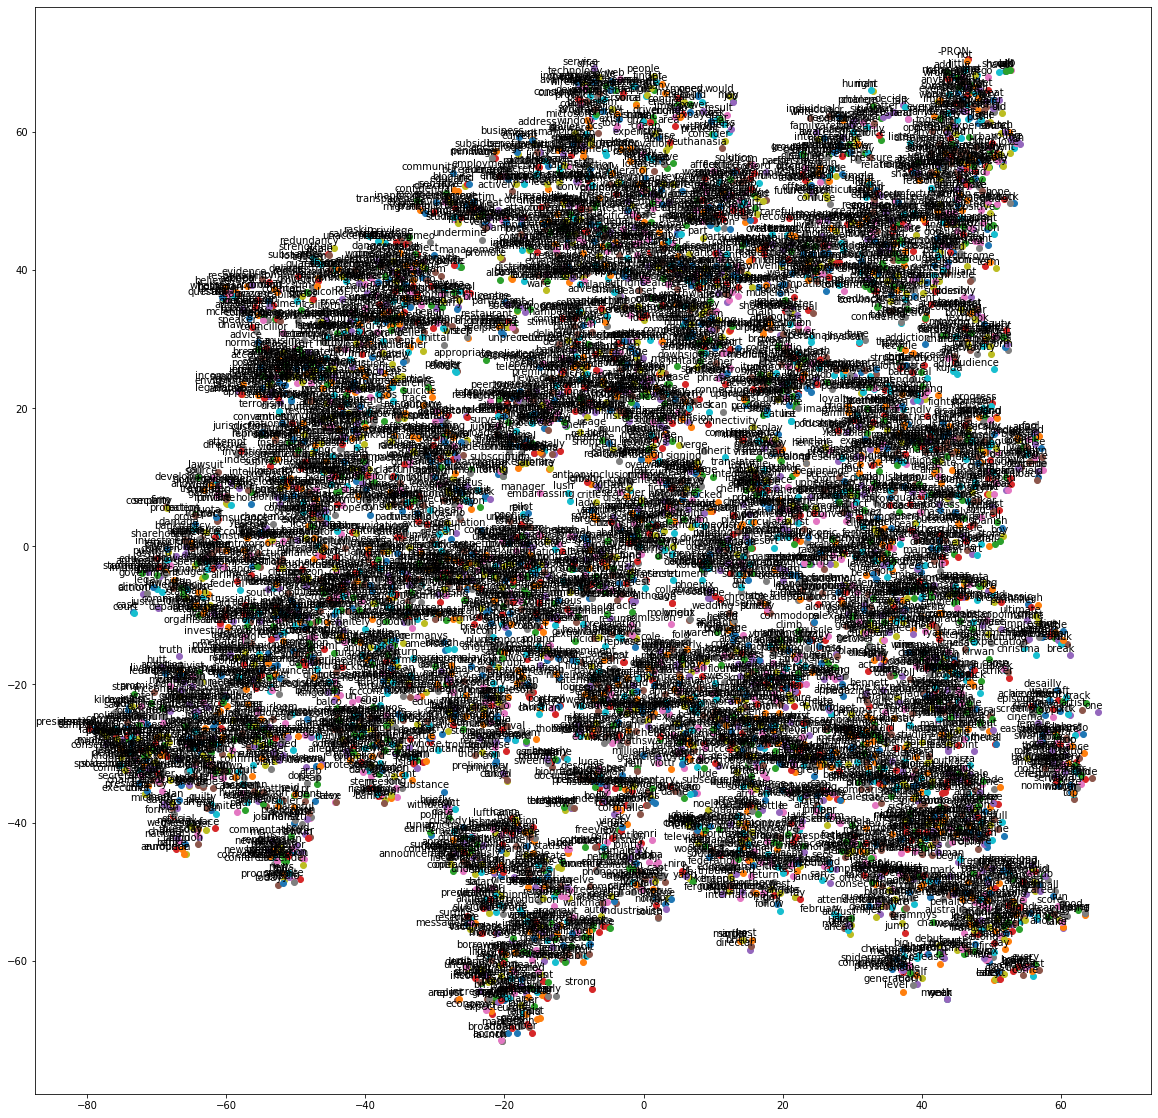

In [19]:
#Visualization of words in space
import sys
from matplotlib import pyplot as plt
%matplotlib inline

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(w2v_model)

In [20]:
vector = w2v_model.wv['america']  # numpy vector of a word
print(len(vector))
print(vector)


200
[-0.122259   -0.06503275  0.07760649 -0.05896242 -0.00427258  0.0154218
 -0.19590946  0.0008402  -0.00227065  0.09057161 -0.04451295 -0.10238971
  0.00886674 -0.03760384 -0.06600333 -0.16871108 -0.09847715 -0.01323507
  0.03737865  0.07073351 -0.01833177  0.1103385   0.02285885  0.03473028
 -0.03448352  0.0186179  -0.1020472   0.06084087  0.01833246  0.04421171
 -0.02898247  0.0844868  -0.00512895 -0.06545006 -0.00161877 -0.10156457
  0.02542987  0.14692818 -0.15173337  0.10877212  0.07845875  0.11212479
  0.0644612  -0.02812817  0.11162693 -0.07885312 -0.09288305  0.13134043
  0.1238177   0.05890479  0.07442616 -0.02783431  0.00287334  0.14348593
  0.15356153  0.03502049  0.06176014 -0.01333885  0.05125644 -0.03652167
  0.0911489   0.04274457 -0.0501571  -0.03686895 -0.05919173 -0.04321623
  0.06094864  0.02096707  0.00785306 -0.01979861 -0.03681496  0.00584468
 -0.01299611  0.00140651 -0.03126219  0.01921181 -0.01536596 -0.09103059
  0.04033173  0.04436263  0.04618056  0.01757359